In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os

import awkward as ak
import uproot
import numpy as np
import glob
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
from coffea import hist, processor
# register our candidate behaviors
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

from functools import partial

from tools.helpers import get_four_vec_fromPtEtaPhiM, match

from yahist import Hist1D, Hist2D

import json

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import mplhep as hep

plt.style.use(hep.style.CMS)  # or ATLAS/LHCb

In [3]:
from tools.helpers import dasWrapper
from analysis.tagger import desired_output

redirector_ucsd = 'root://xcache-redirector.t2.ucsd.edu:2042/'

# maybe we'll need the number of events for weighting, but not at the moment
def get_nevents(name):
    res = dasWrapper(name, query='summary')
    return json.loads(res[0])[0]['nevents']


In [4]:
samples_signal = [
    '/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
]

Z_samples = [
    '/ZJetsToNuNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
]

tt_samples = [
    '/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/TT_Mtt-1000toInf_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
    '/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
    '/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
]

QCD_samples = [
    '/QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
]

W_samples = [
    #'/W0JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM'
    #'/W1JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/W2JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/W3JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/W4JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
    '/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM'
]

rare_samples = [
    '',
]

In [5]:
fileset_signal = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in samples_signal}
fileset_Z = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in Z_samples}
fileset_QCD = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in QCD_samples}
fileset_W = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in W_samples}
fileset_tt = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)][:10] for s in tt_samples}

In [6]:
exe_args = {
    'workers': 12,
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor

fileset = fileset_tt



## Get the efficiencies

In [7]:
from analysis.tagger import measure_eff


output = processor.run_uproot_job(
            fileset,
            "Events",
            measure_eff(accumulator=desired_output),
            exe,
            exe_args,
            chunksize=500000,
        )

Preprocessing:   0%|          | 0/60 [00:00<?, ?file/s]

Processing:   0%|          | 0/82 [00:00<?, ?chunk/s]

In [8]:
def get_efficiency(region, process, mass_range=slice(100,150)):

    pt_bins  = hist.Bin('pt', r'$p_{T} \ (GeV)$', [200, 300, 400, 600, 800])
    eta_bins = hist.Bin('eta', r'$\eta$', 3, 0, 2.4)

    inclusive = output[region][process].rebin('pt', pt_bins).rebin('eta', eta_bins)
    tagged = output[region+'_tagged'][process].rebin('pt', pt_bins).rebin('eta', eta_bins)

    h1 = Hist2D.from_bincounts(
        inclusive.integrate('mass', int_range=mass_range).sum('phi', 'dataset').values()[()].T,
        (
            inclusive.axis('pt').edges(),
            inclusive.axis('eta').edges(),
        )
    )
    
    h2 = Hist2D.from_bincounts(
        tagged.integrate('mass', int_range=mass_range).sum('phi', 'dataset').values()[()].T,
        (
            tagged.axis('pt').edges(),
            tagged.axis('eta').edges(),
        )
    )
    

    return h2.divide(h1)

In [9]:
# check that stuff actually ran

output['1b'].sum('phi', 'mass').integrate('eta', slice(0,1)).integrate('pt', slice(500,1000)).values()

{('ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8',): 82.0,
 ('ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8',): 156.0,
 ('ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',): 554.0,
 ('ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',): 288.0,
 ('TT_Mtt-1000toInf_TuneCP5_13TeV-powheg-pythia8',): 40075.0,
 ('TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8',): 6555.0}

In [10]:
output['1h_tagged'].sum('phi', 'mass').integrate('eta', slice(0,1)).integrate('pt', slice(500,1000)).values()

{('ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8',): 0.0,
 ('ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8',): 0.0,
 ('ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',): 0.0,
 ('ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',): 0.0,
 ('TT_Mtt-1000toInf_TuneCP5_13TeV-powheg-pythia8',): 0.0,
 ('TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8',): 0.0}

In [79]:
6534.0/10065.0

0.6491803278688525

TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8
TT_Mtt-1000toInf_TuneCP5_13TeV-powheg-pythia8
ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8
ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8
ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8
ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8


(<matplotlib.image.PcolorImage at 0x7f942839d9a0>, <AxesSubplot:>)

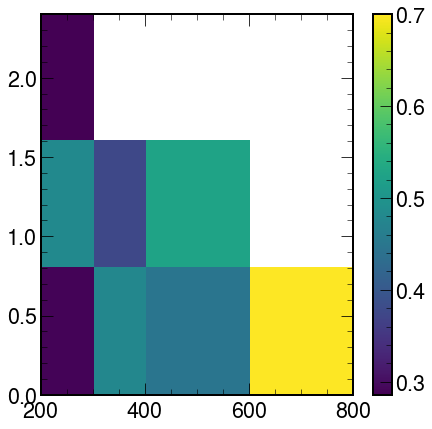

In [12]:
for s in fileset.keys():
    print (s)
    for b in ['0b', '1b', '2b', '1h']:
        #print (b)
        h = get_efficiency(b, s, mass_range=slice(0,500))
        #h.plot()

        h.to_json(os.path.expandvars("../data/htag/eff_%s_%s.json"%(s,b)))
        
        #del h
    
h = get_efficiency(
    '2b',
    'ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8',
    mass_range=slice(0,500),
)
fig, ax = plt.subplots(1,1,figsize=(7,7))
h.plot()

(<matplotlib.image.PcolorImage at 0x7f92503ccc70>, <AxesSubplot:>)

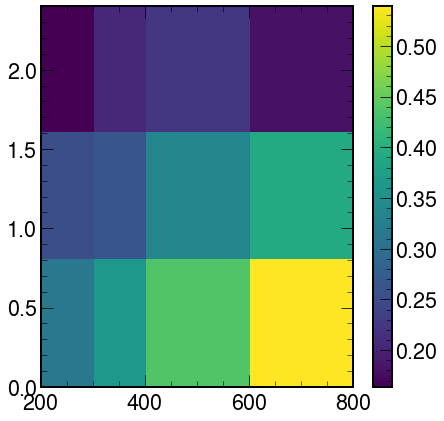

In [17]:
h = get_efficiency(
    '2b',
    'TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8',
    mass_range=slice(0,500),
)
fig, ax = plt.subplots(1,1,figsize=(7,7))
h.plot()

## Apply the efficiency

In [93]:
effs = {}
for s in fileset_Z.keys():
    effs[s] = {}
    print (s)
    for b in ['0b', '1b', '2b', '1h']:
        #print (b)
        #h = get_efficiency(b, s, mass_range=slice(0,500))
        #h.plot()
        effs[s][b] = Hist2D.from_json(os.path.expandvars("../data/htag/eff_%s_%s.json"%(s,b)))
        #effs[s][b] = effs[s][b]*0.95
        
for s in fileset.keys():
    effs[s] = {}
    print (s)
    for b in ['0b', '1b', '2b', '1h']:
        #print (b)
        #h = get_efficiency(b, s, mass_range=slice(0,500))
        #h.plot()
        effs[s][b] = Hist2D.from_json(os.path.expandvars("../data/htag/eff_%s_%s.json"%(s,b)))
        #effs[s][b] = effs[s][b]*0.95

ZJetsToNuNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8
ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8


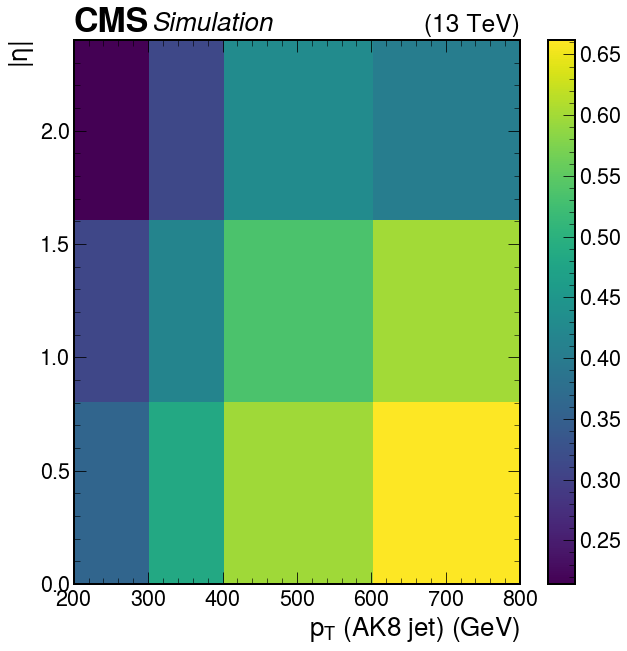

In [94]:
fig, ax = plt.subplots()

hep.cms.label(
    "Simulation",
    data=True,
    #year=2018,
    #lumi=60.0,
    loc=0,
    ax=ax,
)

effs['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8']['1h'].plot()

ax.set_xlabel(r'$p_T\ (AK8\ jet)\ (GeV)$')
ax.set_ylabel(r'$|\eta|$')

plt.show()

fig.savefig('/home/users/dspitzba/public_html/HbbMET/1h_true_eff.png')
fig.savefig('/home/users/dspitzba/public_html/HbbMET/1h_true_eff.pdf')


In [42]:
effs['ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8']['1b']*1.05

[[ 0.27 ± 0.01    0.18 ± 0.01    0.16 ± 0.01    0.18 ± 0.02]
 [ 0.20 ± 0.01    0.12 ± 0.01    0.11 ± 0.01    0.10 ± 0.02]
 [ 0.09 ± 0.01    0.07 ± 0.01    0.05 ± 0.01    0.02 ± 0.02]]

In [43]:
effs['ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8']['1b'].counts

array([[0.26036866, 0.17354754, 0.1568438 , 0.17021277],
       [0.19107622, 0.11665128, 0.10434057, 0.09259259],
       [0.08163265, 0.06629834, 0.04867257, 0.01449275]])

In [44]:
np.isnan(sum(sum(effs['ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8']['1h'].counts)))

True

In [45]:
from tools.helpers import yahist_2D_lookup
yahist_2D_lookup(
    effs['ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8']['0b'],
    ak.Array([[700]]),
    ak.Array([[2.]]),
)

<Array [[0.00195]] type='1 * var * float64'>

In [97]:
from analysis.tagger import apply_eff, desired_output

exe_args = {
    'workers': 12,
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}

output = processor.run_uproot_job(
            fileset_Z,
            "Events",
            apply_eff(
                accumulator=desired_output,
                effs = effs,
            ),
            exe,
            exe_args,
            chunksize=500000,
        )

Processing:   0%|          | 0/218 [00:00<?, ?chunk/s]

### Closure and sanity checks

Make sure that the method closes in pt, and gives reasonable agreement in the mass distribution.


In [98]:
# if inclusive number below is nan we have a bug in applying the efficiencies.
output['inclusive'].sum('pt', 'eta', 'phi', 'mass').values()

{('ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8',): 2261.29967650816,
 ('ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8',): 843.6441674018162,
 ('ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8',): 8717.163300381211,
 ('ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8',): 14786.910422661294,
 ('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): 27094.156602625975,
 ('ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8',): 12060.999999999998,
 ('ZJetsToNuNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8',): 330.0}

In [99]:
# inclusive and tagged numbers should agree within percent level
output['tagged'].sum('pt', 'eta', 'phi', 'mass').values()

{('ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8',): 2360.0,
 ('ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8',): 929.0,
 ('ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8',): 8828.0,
 ('ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8',): 14795.0,
 ('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): 27094.0,
 ('ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8',): 12061.0,
 ('ZJetsToNuNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8',): 331.0}

In [110]:
output['tagged'][sname].sum('phi', 'mass', 'eta', 'dataset').values(sumw2=True)

{(): (array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.539e+03, 1.257e+03,
         1.081e+03, 1.016e+03, 8.070e+02, 7.090e+02, 6.630e+02, 6.800e+02,
         6.940e+02, 7.590e+02, 7.310e+02, 7.420e+02, 6.430e+02, 6.130e+02,
         4.960e+02, 4.330e+02, 3.150e+02, 2.950e+02, 2.610e+02, 2.190e+02,
         1.960e+02, 1.630e+02, 1.420e+02, 9.300e+01, 6.300e+01, 6.100e+01,
         4.700e+01, 3.000e+01, 1.800e+01, 7.000e+00, 1.500e+01, 6.000e+00,
         1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00]),
  array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.539e+03, 1.257e+03,
         1.081e+03, 1.016e+03, 8.070e+02, 7.090e+02, 6.630e+02, 6.800e+02,
         6.940e+02, 7.590e+02, 7.310e+02, 7.420e+02, 6.430e+02, 6.130e+02,
         4.960e+02, 4.330e+02, 3.150e+02, 2.950e+02, 2.610e+02,

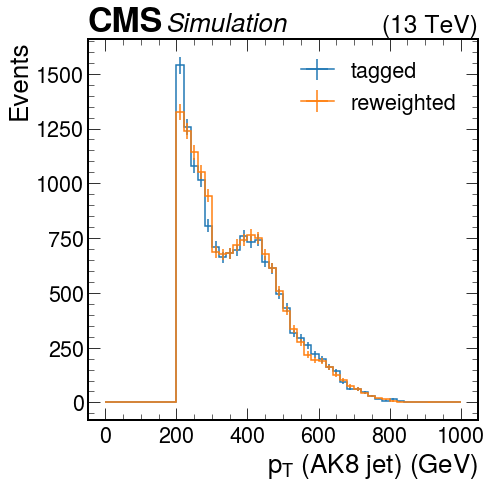

In [111]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

hep.cms.label(
    "Simulation",
    data=True,
    #year=2018,
    #lumi=60.0,
    loc=0,
    ax=ax,
)

sname = 'ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8'

vals_tagged = output['tagged'][sname].sum('phi', 'mass', 'eta', 'dataset').values()[()]
vals_inclusive = output['inclusive'][sname].sum('phi', 'mass', 'eta', 'dataset').values()[()]

hep.histplot(
    [ vals_tagged, vals_inclusive ],
    output['inclusive'][sname].axis('pt').edges(),
    w2=[ vals_tagged, vals_inclusive ],
    histtype="step",
    stack=False,
    label=['tagged', 'reweighted'],
    #color=[ my_histos[x].color for x in keys ],
    ax=ax)

ax.legend()

ax.set_xlabel(r'$p_T\ (AK8\ jet)\ (GeV)$')
ax.set_ylabel(r'Events')

plt.show()

fig.savefig('/home/users/dspitzba/public_html/HbbMET/tagging/application_pt.png')
fig.savefig('/home/users/dspitzba/public_html/HbbMET/tagging/application_pt.pdf')



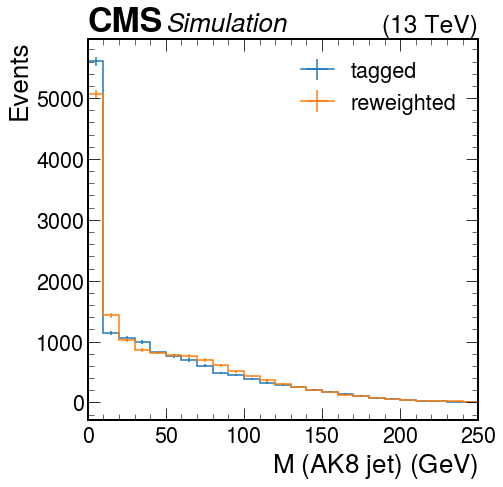

In [114]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

hep.cms.label(
    "Simulation",
    data=True,
    #year=2018,
    #lumi=60.0,
    loc=0,
    ax=ax,
)

sname = 'ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8'

vals_tagged = output['tagged'][sname].sum('phi', 'pt', 'eta', 'dataset').values()[()]
vals_inclusive = output['inclusive'][sname].sum('phi', 'pt', 'eta', 'dataset').values()[()]

hep.histplot(
    [ vals_tagged, vals_inclusive ],
    output['inclusive'][sname].axis('mass').edges(),
    w2=[ vals_tagged, vals_inclusive ],
    histtype="step",
    stack=False,
    label=['tagged', 'reweighted'],
    #color=[ my_histos[x].color for x in keys ],
    ax=ax)

ax.legend()

ax.set_xlabel(r'$M\ (AK8\ jet)\ (GeV)$')
ax.set_ylabel(r'Events')

ax.set_xlim([0,250])

plt.show()

fig.savefig('/home/users/dspitzba/public_html/HbbMET/tagging/application_mass.png')
fig.savefig('/home/users/dspitzba/public_html/HbbMET/tagging/application_mass.pdf')



<AxesSubplot:>

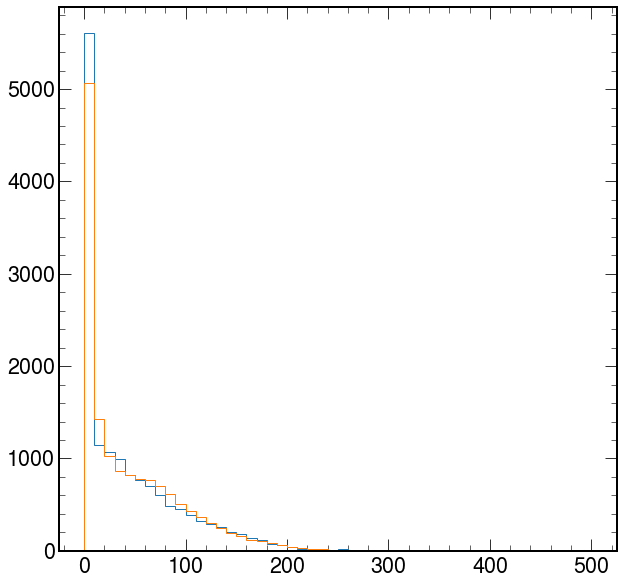

In [50]:
h1 = Hist1D.from_bincounts(
        output['tagged'][sname].sum('phi', 'pt', 'eta', 'dataset').values()[()],
        output['tagged'][sname].axis('mass').edges(),
    )

h2 = Hist1D.from_bincounts(
        output['inclusive'][sname].sum('phi', 'pt', 'eta', 'dataset').values()[()],
        output['inclusive'][sname].axis('mass').edges(),
    )
h1.plot()
h2.plot()

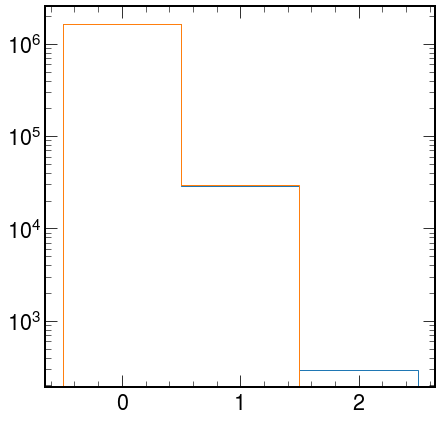

In [51]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

h1 = Hist1D.from_bincounts(
        output['NH_true'][sname].sum('dataset').values()[()],
        output['NH_true'][sname].axis('multiplicity').edges(),
    )

h2 = Hist1D.from_bincounts(
        output['NH_weight'][sname].sum('dataset').values()[()],
        output['NH_weight'][sname].axis('multiplicity').edges(),
    )
h1.plot()
h2.plot()

ax.set_yscale('log')

### Compare prediction of tagged jets in the interesting mass window

In [52]:
output['inclusive'][sname].integrate('mass', int_range=slice(100,150)).sum('phi', 'pt', 'eta', 'dataset').values()[()]

1539.101715319699

In [53]:
output['tagged'][sname].integrate('mass', int_range=slice(100,150)).sum('phi', 'pt', 'eta', 'dataset').values()[()]

1462.0

In [54]:
1539.101715319699/1462.0

1.052737151381463

In [ ]:
test_eff = ak.Array([[0.1,0.2], [0.15], []])
1-ak.prod(1-test_eff, axis=1)

In [ ]:
np.zeros_like(ak.num(test_eff))

In [39]:
output['NH_true'][sname].values()

{('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): array([1.348125e+06, 1.727500e+04, 4.100000e+01])}

In [40]:
output['NH_weight'][sname].values()

{('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): array([1347971.26474227,   17205.73525705,       0.        ])}

In [ ]:
54281.68960112/(5.3884000e+04+1.7600000e+02)

## WIP

In [ ]:
def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
       Version from Jonathan Guiang: https://gist.github.com/jkguiang/279cb4d2e68e64148afc62274df09f18
    """
    return a * (1.0 - (0.299 * r + 0.587 * g + 0.114 * b))

def bin_text(counts, x_edges, y_edges, axes, cbar, errors=None, size=10, fmt=":0.2e"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
       Version from Jonathan Guiang: https://gist.github.com/jkguiang/279cb4d2e68e64148afc62274df09f18
    """
    show_errors = (type(errors) != type(None))
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2
    
    if show_errors:
        label_template = r"{0"+fmt+"}\n$\pm{1:0.2f}\%$"
    else:
        errors = np.zeros(counts.shape)
        label_template = r"{0"+fmt+"}"
        
    xyz = np.c_[        
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
        errors.flatten()
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, count, err), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            label_template.format(count, err),
            color=color,
            ha="center",
            va="center",
            fontsize=size,
            wrap=True,
        )

    return

In [ ]:
h2.divide(h1).counts

In [ ]:
h2.edges[0]